In [1]:
from model import *
import os

In [2]:
input_path = './new_data/king.wav'
filename, ext = os.path.splitext(input_path)
result_path = f'{filename}_processed{ext}'

rel = 10
att = 220
att_mul = 1.5
mbatch = 4096

init_level = 0.2
scale = 2
damp = False

performQuad = True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = convNet()
net.load_state_dict(torch.load('./models/ka_model.pth'))
net = net.to(device)

(3, 80, 15139)

In [12]:
p_audio = Audio(input_path, stereo=False)
p_features = fft_and_melscale(p_audio, include_zero_cross=False)

with torch.no_grad():
    result = net.infer(p_features, device, minibatch=mbatch)

if performQuad:
    result = result ** 2

d:\Coding\ML\neurals\odcnn\music_processor.py:192: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fft_and_melscale" failed type inference due to: Untyped global name 'mel': Cannot determine Numba type of <class 'function'>

File "music_processor.py", line 206:
def fft_and_melscale(song, nhop=512, nffts=[1024, 2048, 4096], mel_nband=80, mel_freqlo=27.5, mel_freqhi=16000.0, include_zero_cross=False):
    <source elided>
        window = signal.blackmanharris(nfft)
        filt = mel(song.samplerate, nfft, mel_nband, mel_freqlo, mel_freqhi)
        ^

  @jit
c:\Users\killm\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "fft_and_melscale" was compiled in object mode without forceobj=True.

File "music_processor.py", line 193:
@jit
def fft_and_melscale(song, nhop=512, nffts=[1024, 2048, 4096], mel_nband=80, mel_freqlo=27.5, mel_freqhi=16000.0, include_zero_cross=False):
^

  warnings.warn(errors.

In [13]:
def to_shape1D(a, shape):
    y_ = shape[0]
    y = a.shape[0]
    y_pad = (y_ - y)
    return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2),), 
                  mode = 'constant')

In [14]:
def single_pole(data, sample_rate, nfft, att_time=10, rel_time=10):
    true_sr = sample_rate / nfft

    coeff1 = 1.0 - np.exp2(-1.0 / max(att_time * true_sr * 0.001, 0.02))
    coeff2 = 1.0 - np.exp2(-1.0 / max(rel_time * true_sr * 0.001, 0.02))
    result = data.copy()

    z1 = 0.0

    for i in range (len(result)):
        in_ = data[i]
        f = abs(in_)

        coeff = coeff1 if f > z1 else coeff2   
        z1 = coeff * (f - z1) + z1     
     
        result[i] = z1

    return result

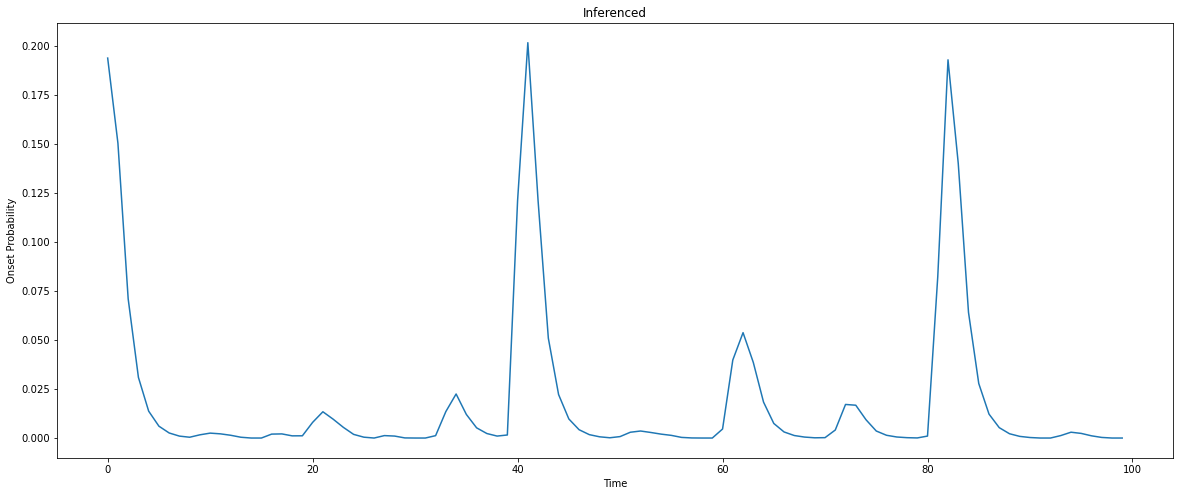

In [15]:
filtered_rel = single_pole(result, p_audio.samplerate, 512, 0, rel)
filtered_att = single_pole(result, p_audio.samplerate, 512, att, rel) * att_mul

filtered_diff = (filtered_rel - filtered_att).clip(min=0) #filtered_rel

plt.figure(figsize=(20,8))
plt.title("Inferenced")
plt.xlabel("Time")
plt.ylabel("Onset Probability")
plt.plot(filtered_diff[2000:2100])

In [16]:
from librosa.util import peak_pick, normalize
from librosa import resample

#filtered_diff = np.tanh(filtered_diff * 5)
ka_inference = np.concatenate([np.zeros(5), filtered_diff])

# ka_timestamp = peak_pick(ka_inference, 1, 3, 3, 4, 0.02, 5) # + 7 # 7 is magic number of output delay (i guess)#
# ka_peak_picked = ka_inference[ka_timestamp]

#plt.figure(figsize=(20,8))
#plt.title("Inferenced")
#plt.xlabel("Time")
#plt.ylabel("Onset Probability")
#plt.plot(np.linspace(0, len(ka_inference), len(ka_peak_picked)), ka_peak_picked)

upsampled_fft = resample(ka_inference, p_audio.samplerate / 512, p_audio.samplerate) 
scaled = scale * to_shape1D(upsampled_fft, p_audio.data.shape)
p_result = p_audio.data * (init_level + scaled if not damp else init_level - scaled)

sf.write(result_path, p_result, p_audio.samplerate)

C:\Users\killm\AppData\Local\Temp\ipykernel_16276\2881602670.py:16: FutureWarning: Pass orig_sr=86.1328125, target_sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  upsampled_fft = resample(ka_inference, p_audio.samplerate / 512, p_audio.samplerate)


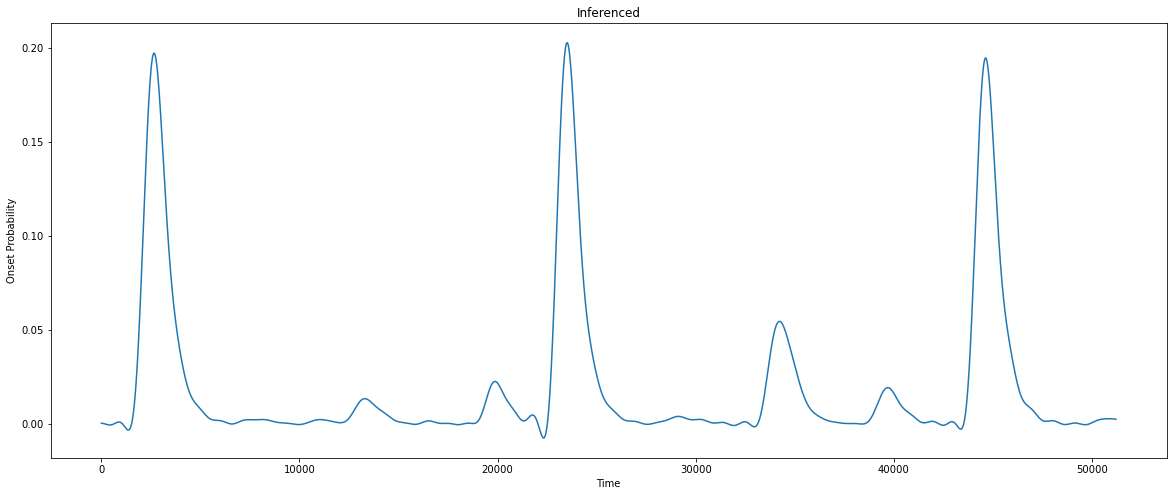

In [17]:
plt.figure(figsize=(20,8))
plt.title("Inferenced")
plt.xlabel("Time")
plt.ylabel("Onset Probability")
plt.plot(upsampled_fft[2000*512:2100*512])